<a href="https://colab.research.google.com/github/beatlesatani/coding_september/blob/main/sentiment_analysis_with_pretrained_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 14.1 MB/s eta 0:00:00


In [2]:

 pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 21.7 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=cc41d805eea3bbfeacfb87d36408fe4c7d1fe79ed19e82a38a86d5b58aae6e03
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.0 MB/s eta 0:00:00


In [4]:
import os
import shutil
import re
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

In [5]:
#setup the dataset
test = 'https://raw.githubusercontent.com/beatlesatani/coding_september/main/test.csv'
train = "https://raw.githubusercontent.com/beatlesatani/coding_september/main/train.csv"
test = pd.read_csv(test,encoding='unicode_escape')
train = pd.read_csv(train,encoding='unicode_escape')
# remove unusuful columns
test = test.iloc[:,1:3]
train = train.iloc[:, [1,3]]
#check the insull values of train dataframe
train.isnull().sum()
#only one text is missing, so drop that low that incluse null cell
train = train.dropna()
#re-check null values
train.isnull().sum()

text         0
sentiment    0
dtype: int64

In [6]:
#check the insull values of train dataframe
test.isnull().sum()

text         1281
sentiment    1281
dtype: int64

In [7]:
#afeter checking original csv file, all raws after 3533 is null
test = test.dropna()
#re-check null values
test.isnull().sum()

text         0
sentiment    0
dtype: int64

In [8]:
#check the label imbalance
train['sentiment'].value_counts(normalize=True)

neutral     0.404549
positive    0.312300
negative    0.283151
Name: sentiment, dtype: float64

In [9]:
test['sentiment'].value_counts(normalize=True)

neutral     0.404641
positive    0.312111
negative    0.283248
Name: sentiment, dtype: float64

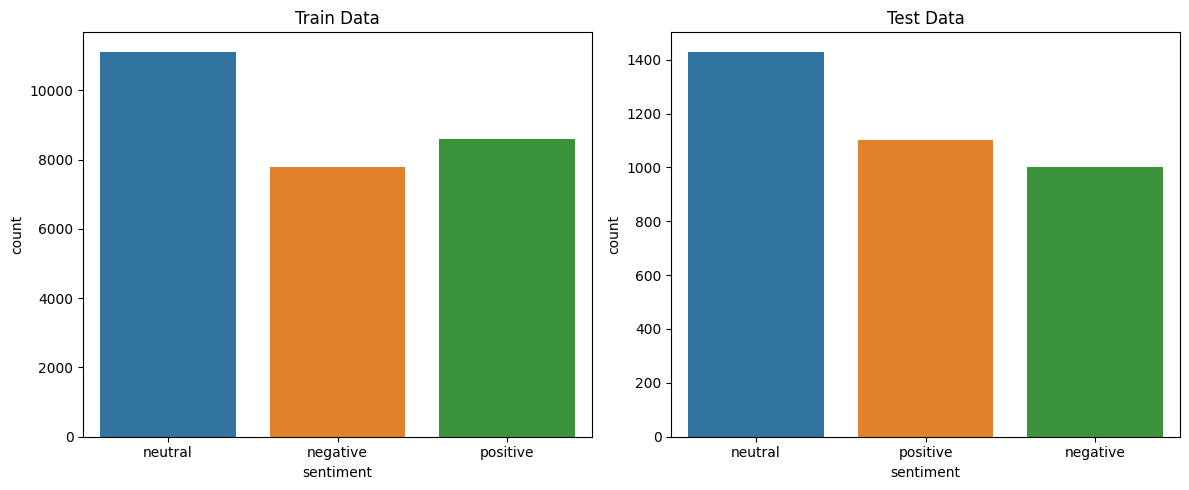

In [10]:
#graph
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='sentiment', data=train, ax=axes[0],saturation = 0.75)
axes[0].set_title('Train Data')

# Plot the countplot for 'sentiment' in the 'test' DataFrame
sns.countplot(x='sentiment', data=test, ax=axes[1])
axes[1].set_title('Test Data')

# Adjust layout for better visibility
plt.tight_layout()

# Show the plots
plt.show()

## we can conclude the labels are not inbalanced

## convert each sentiment into numerical value
neagtive → -1
neutral → 0
postive → 1

In [11]:
#before working to the model, convert labels into numerical number
train['label'] = train['sentiment'].apply(lambda x: -1 if x== 'negative' else(0 if x == 'neutral' else 1))
train = train.drop('sentiment',axis = 1)
test['label'] = test['sentiment'].apply(lambda x: -1 if x== 'negative' else(0 if x == 'neutral' else 1))
test = test.drop('sentiment',axis = 1)

In [12]:
train['label'].value_counts(normalize=True) # got same ratio before converting

 0    0.404549
 1    0.312300
-1    0.283151
Name: label, dtype: float64

In [13]:
#split the dataset
X_train = train['text']
y_train = train['label']
X_test = test['text']
y_test = test['label']

In [14]:
#convert label to one-hot-coding
y_train = pd.get_dummies(y_train, columns = ['label'])
y_test = pd.get_dummies(y_test, columns = ['label'])

## From here I will use transformer library from Hugging-face.
The transformer library of Hugging Face contains PyTorch implementation of state-of-the-art NLP models including BERT (from Google), GPT (from OpenAI) ... and pre-trained model weights.

In [15]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [16]:
X_train.iloc[:20,]

0                   I`d have responded, if I were going
1         Sooo SAD I will miss you here in San Diego!!!
2                             my boss is bullying me...
3                        what interview! leave me alone
4      Sons of ****, why couldn`t they put them on t...
5     http://www.dothebouncy.com/smf - some shameles...
6     2am feedings for the baby are fun when he is a...
7                                            Soooo high
8                                           Both of you
9      Journey!? Wow... u just became cooler.  hehe....
10     as much as i love to be hopeful, i reckon the...
11    I really really like the song Love Story by Ta...
12         My Sharpie is running DANGERously low on ink
13    i want to go to music tonight but i lost my vo...
14                           test test from the LG enV2
15                                Uh oh, I am sunburned
16     S`ok, trying to plot alternatives as we speak...
17    i`ve been sick for the past few days  and 

In [17]:
# Print sentence 0
print('Original: ', X_train[0])
print('Processed: ', text_preprocessing(X_train[0]))

Original:   I`d have responded, if I were going
Processed:  I`d have responded, if I were going


In [18]:
#The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them.
#同じlengthで読み込むために不用意に伸ばされた部分は無視してねっていうこと

In [19]:
#I can use pre_trained bert model from transformers library in hugging-face
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [20]:
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [23]:
# Concatenate train data and test data
all_tweets = np.concatenate([train.text.values, test.text.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  110


In [24]:

MAX_LEN = 120

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X_test[0]])[0].squeeze().numpy())
print('Original: ', X_test[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  Last session of the day  http://twitpic.com/67ezh
Token IDs:  [101, 2197, 5219, 1997, 1996, 2154, 8299, 1024, 1013, 1013, 1056, 9148, 25856, 2594, 1012, 4012, 1013, 6163, 9351, 2232, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [38]:
train_

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [28]:
y_train

,-1,0,1
0,0,1,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
27476,1,0,0
27477,1,0,0
27478,0,0,1
27479,0,0,1


In [39]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_test.values)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [56]:
train_dataloader

In [40]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 3

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 118 ms, sys: 6.9 ms, total: 125 ms
Wall time: 241 ms


In [41]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [50]:
import torch
import torch.nn as nn
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split

# Define hyperparameters
PRE_TRAINED_MODEL_NAME = "distilbert-base-uncased"
NUM_CLASSES = 3
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
EPOCHS = 4

# Initialize DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=NUM_CLASSES)

# Move the model to the appropriate device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load and preprocess your dataset (assuming you have tokenized inputs and labels as integers)
# Replace with your actual data loading and preprocessing steps
# For example, if you have a list of tokenized input IDs and labels:
#input_ids = [...]  # List of tokenized input IDs
#labels = [...]     # List of integer labels

# Convert data to PyTorch tensors
input_ids = torch.tensor(input_ids)
labels = torch.tensor(labels)

# Create a DataLoader for your dataset
dataset = TensorDataset(input_ids, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Define the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, labels=labels)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Print training loss for this epoch
    print(f"Epoch {epoch + 1}/{EPOCHS} - Loss: {total_loss / len(train_dataloader):.4f}")

# Evaluation
model.eval()
val_loss = 0.0
correct_predictions = 0

with torch.no_grad():
    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, labels = batch
        outputs = model(input_ids)
        loss = loss_fn(outputs.logits, labels)
        val_loss += loss.item()
        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

# Calculate validation accuracy
accuracy = correct_predictions.double() / len(val_dataset)
print(f"Validation Loss: {val_loss / len(val_dataloader):.4f}")
print(f"Validation Accuracy: {accuracy:.2%}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: ignored

NameError: ignored